# RNA Multi-Perceptrón Backpropagation para procesar las imágenes e identificar si es una botella normal, un bidón retornable o un bidón plástico.

## Cargar librerías:

In [235]:
!sudo apt install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [236]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import keras
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.utils import plot_model

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import sys
import shutil

IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
  print('Running on Google Colab')

print("Librerías cargadas")

Running on Google Colab
Librerías cargadas


## Definir los parámetros:

In [237]:
# tamaño de las imágenes
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 1)

# define tamaño de datos de entrada 
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]


# define tamaño de datos de salida (las clases están codificadas en un único número)
num_outputs = 1 

# cantidad de neuronas ocultas 
hidden_layers_neuron_counts = [ 3000, 1024, 512 ] 


# cantidad de iteraciones del entrenamiento
epochs_count = 100

# print("Configuración de RNA MLP Backpropagation definida: [", num_inputs, hidden_layers_neuron_counts, num_outputs," ] ")

### Algunas otras burocracias..

In [238]:
if IS_COLAB:
    DATASET_PATH = '/content/datasets'
else:
    DATASET_PATH = './datasets'

IMAGE_CLASSES = ['bidon_plastico', 'botella_normal', 'bidon_retornable']
RAW_PATH = os.path.join(DATASET_PATH, 'raw')
MINIFIED_PATH = os.path.join(DATASET_PATH, 'minified')

if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)


print('Done!')

Done!


## Descarga las imagenes de drive, si se está corriendo en colab

In [239]:
! cd datasets && rm -rf raw && svn checkout https://github.com/CorridoniMatias/detector-botellas-ia/trunk/datasets/raw

A    raw/bidon_plastico
A    raw/bidon_plastico/0001.jpg
A    raw/bidon_plastico/0002.jpg
A    raw/bidon_plastico/0003.jpg
A    raw/bidon_plastico/0004.jpg
A    raw/bidon_plastico/0005.jpg
A    raw/bidon_plastico/0006.jpg
A    raw/bidon_plastico/0007.jpg
A    raw/bidon_plastico/0008.jpg
A    raw/bidon_plastico/0009.jpg
A    raw/bidon_plastico/0010.jpg
A    raw/bidon_plastico/0011.jpg
A    raw/bidon_plastico/0012.jpg
A    raw/bidon_plastico/0013.jpg
A    raw/bidon_plastico/0014.jpg
A    raw/bidon_plastico/0015.jpg
A    raw/bidon_plastico/0016.jpg
A    raw/bidon_plastico/0017.jpg
A    raw/bidon_plastico/0018.jpg
A    raw/bidon_plastico/0019.jpg
A    raw/bidon_plastico/0020.jpg
A    raw/bidon_plastico/0021.jpg
A    raw/bidon_plastico/0022.jpg
A    raw/bidon_plastico/0023.jpg
A    raw/bidon_plastico/0024.jpg
A    raw/bidon_plastico/0025.jpg
A    raw/bidon_plastico/0026.jpg
A    raw/bidon_plastico/0027.jpg
A    raw/bidon_plastico/0028.jpg
A    raw/bidon_plastico/0029.jpg
A    raw/bidon_plas

## Preprocesamiento de imágenes
Las imágenes se achican a un tamaño de 64x64 y se convierten a escala de grises.

In [240]:
def minimized_image(image):
    return image.convert('L').resize((IMAGE_HEIGHT, IMAGE_WIDTH), Image.ANTIALIAS)

def minify_image_from_class(from_directory, to_directory):
    for root, dirs, files in os.walk(from_directory):
        for image_name in files:
            image_path = os.path.join(root, image_name)
            print(image_path)
            image = Image.open(image_path)
            image = minimized_image(image)
            image.save(os.path.join(to_directory, image_name))

for image_class in IMAGE_CLASSES:
    input_dir = os.path.join(RAW_PATH, image_class)
    output_dir = os.path.join(MINIFIED_PATH, image_class)

    if os.path.exists(output_dir):
      shutil.rmtree(output_dir)
    
    os.makedirs(output_dir)
    minify_image_from_class(input_dir, output_dir)

print('Done')


/content/datasets/raw/bidon_plastico/0032.jpg
/content/datasets/raw/bidon_plastico/0036.jpg
/content/datasets/raw/bidon_plastico/0011.jpg
/content/datasets/raw/bidon_plastico/0035.jpg
/content/datasets/raw/bidon_plastico/0040.jpg
/content/datasets/raw/bidon_plastico/0005.jpg
/content/datasets/raw/bidon_plastico/0019.jpg
/content/datasets/raw/bidon_plastico/0007.jpg
/content/datasets/raw/bidon_plastico/0039.jpg
/content/datasets/raw/bidon_plastico/0001.jpg
/content/datasets/raw/bidon_plastico/0014.jpg
/content/datasets/raw/bidon_plastico/0028.jpg
/content/datasets/raw/bidon_plastico/0018.jpg
/content/datasets/raw/bidon_plastico/0037.jpg
/content/datasets/raw/bidon_plastico/0029.jpg
/content/datasets/raw/bidon_plastico/0004.jpg
/content/datasets/raw/bidon_plastico/0024.jpg
/content/datasets/raw/bidon_plastico/0010.jpg
/content/datasets/raw/bidon_plastico/0038.jpg
/content/datasets/raw/bidon_plastico/0008.jpg
/content/datasets/raw/bidon_plastico/0021.jpg
/content/datasets/raw/bidon_plasti

In [241]:


import math
import re
import sys
import shutil

DISTRIBUTED_PATH = os.path.join(DATASET_PATH, 'distributed')
#Train and Test Set Variables
train_val_test_ratio = (.5,.25,.25) # 50/25/25 Data Split
test_folder = os.path.join(DISTRIBUTED_PATH, 'test')
train_folder = os.path.join(DISTRIBUTED_PATH, 'train')
val_folder = os.path.join(DISTRIBUTED_PATH, 'val')

#Remove Existing Folders if they exist
for folder in [test_folder, train_folder, val_folder]:
    if os.path.exists(folder) and os.path.isdir(folder):
        shutil.rmtree(folder)

#Remake Category Folders in both Train and Test Folders
for category in IMAGE_CLASSES:
    os.makedirs(os.path.join(test_folder, category))
    os.makedirs(os.path.join(train_folder, category))
    os.makedirs(os.path.join(val_folder, category))

#Split Data by Train Ratio and copy files to correct directory
for idx, category in enumerate(IMAGE_CLASSES):
    file_list = os.listdir(os.path.join(MINIFIED_PATH, category))
    
    train_ratio = math.floor(len(file_list) * train_val_test_ratio[0])
    val_ratio = math.floor(len(file_list) * train_val_test_ratio[1])
    train_list = file_list[:train_ratio]
    val_list = file_list[train_ratio:train_ratio + val_ratio]
    test_list = file_list[train_ratio + val_ratio:]
    
    for i, file in enumerate(train_list):
        shutil.copy(os.path.join(MINIFIED_PATH, category, file), os.path.join(train_folder, category, file))
    sys.stdout.write('Moving %s train images to category folder %s' % (len(train_list), category))  
    sys.stdout.write('\n')
    for i, file in enumerate(val_list):
        shutil.copy(os.path.join(MINIFIED_PATH, category, file), os.path.join(val_folder, category, file))
    sys.stdout.write('Moving %s validation images to category folder %s' % (len(val_list), category))                   
    sys.stdout.write('\n')
    for i, file in enumerate(test_list):
        shutil.copy(os.path.join(MINIFIED_PATH, category, file), os.path.join(test_folder, category, file))
    sys.stdout.write('Moving %s test images to category folder %s' % (len(test_list), category))
    sys.stdout.write('\n\n')
    
print("Done.")  

Moving 20 train images to category folder bidon_plastico
Moving 10 validation images to category folder bidon_plastico
Moving 10 test images to category folder bidon_plastico

Moving 19 train images to category folder botella_normal
Moving 9 validation images to category folder botella_normal
Moving 11 test images to category folder botella_normal

Moving 21 train images to category folder bidon_retornable
Moving 10 validation images to category folder bidon_retornable
Moving 11 test images to category folder bidon_retornable

Done.


## Carga de imágenes

In [242]:
# Loads images and labels into numpy arrays
def load_img_directory(dir_path):
  classes = []
  images = []
  for class_name in os.listdir(dir_path):
    for image_name in os.listdir(os.path.join(dir_path, class_name)):          
          image = Image.open(os.path.join(dir_path, class_name, image_name))
          images.append(np.array(image))
          classes.append(class_name)
  return (images, classes)

In [243]:
# cargar las imágenes

(x_train, y_train) = load_img_directory(train_folder)
(x_val, y_val) = load_img_directory(val_folder)
(x_test, y_test) = load_img_directory(test_folder)

print('Dataset de train')
print("- Clases cargadas: ", len(set(y_train)))
print("- Imágenes cargadas: ", len(x_train))
print('')

print('Dataset de validación')
print("- Clases cargadas validación: ", len(set(y_val)))
print("- Imágenes cargadas validación: ", len(x_val))
print('')

print('Dataset de test')
print("- Clases cargadas test: ", len(set(y_test)))
print("- Imágenes cargadas test: ", len(x_test))
print('')

Dataset de train
- Clases cargadas:  3
- Imágenes cargadas:  60

Dataset de validación
- Clases cargadas validación:  3
- Imágenes cargadas validación:  29

Dataset de test
- Clases cargadas test:  3
- Imágenes cargadas test:  32



In [244]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(len(label_batch)):
      ax = plt.subplot(4,7,n+1)
      plt.title(label_batch[n])
      plt.imshow(image_batch[n])
      plt.gray()
      plt.axis('off')

['bidon_plastico', 'botella_normal', 'bidon_retornable']
{'bidon_plastico': 0, 'botella_normal': 1, 'bidon_retornable': 2}
x_train (cant ejemplos, datos entrada):  (60, 4096)
y_train (cant):  60

Imagen reconstruida de  bidon_plastico


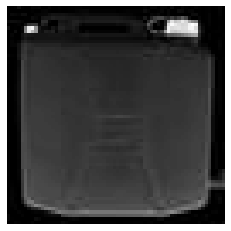

In [245]:
# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")

# define función auxiliar para preparar la lista de imágenes a procesar
def process_images_array(images):    
  images = np.array(images).astype('float32') / 255.
  return images.reshape((len(images), num_inputs))

def process_classes_array(classes):
  mapped = []
  for klass in classes:
    mapped.append(IMAGE_CLASSES_MAP[klass])
  return np.array(mapped)

# define vector auxiliar de datos de entrada para usar en el entrenamiento
_x_train = process_images_array(x_train)
_x_test = process_images_array(x_test)
_x_val = process_images_array(x_val)

# define vector auxiliar de datos de salida para usar en el entrenamiento
# también usa esta información para determinar la cantida de neuronas de salida
print(IMAGE_CLASSES)
IMAGE_CLASSES_MAP = dict(zip(IMAGE_CLASSES, range(len(IMAGE_CLASSES))))
print(IMAGE_CLASSES_MAP)

_y_train = process_classes_array(y_train)
_y_test = process_classes_array(y_test)
_y_val = process_classes_array(y_val)

print("x_train (cant ejemplos, datos entrada): ", _x_train.shape)
print("y_train (cant): ", len(y_train))
print("\nImagen reconstruida de ", y_train[0])

plot_image(x_train[0])

## Definiendo el modelo

In [246]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

#Visualize Model Helper function
def visualize_model(model):
  return SVG(model_to_dot(model).create(prog='dot', format='svg'))

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 4096)]            0         
_________________________________________________________________
dense_39 (Dense)             (None, 3000)              12291000  
_________________________________________________________________
dense_40 (Dense)             (None, 1024)              3073024   
_________________________________________________________________
dense_41 (Dense)             (None, 512)               524800    
_________________________________________________________________
output (Dense)               (None, 1)                 513       
Total params: 15,889,337
Trainable params: 15,889,337
Non-trainable params: 0
_________________________________________________________________


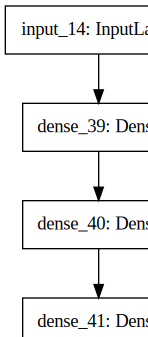

In [247]:
import functools
import pydot

input_layer = Input(shape=(IMAGE_HEIGHT * IMAGE_WIDTH,))

hidden_layers = functools.reduce(   lambda previous_layer, neurons_count: Dense(neurons_count, activation="relu")(previous_layer),
                                    hidden_layers_neuron_counts,
                                    input_layer)

output_layer = Dense(num_outputs, activation=None, name='output')(hidden_layers)

model = Model(input_layer, output_layer)
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

model.summary()
visualize_model(model)

## Entrenar el modelo:

In [248]:
# lleva a cabo el entrenamiento
model.fit(_x_train, _y_train, epochs = epochs_count, batch_size = 6, validation_data=(_x_val, _y_val))

Epoch 1/100
10/10 [==============================] - 0s 20ms/step - loss: 25718.5645 - accuracy: 0.2833 - val_loss: 3.1076 - val_accuracy: 0.3448
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 1.1982 - accuracy: 0.3833 - val_loss: 0.6906 - val_accuracy: 0.3103
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 0.8430 - accuracy: 0.3667 - val_loss: 0.6780 - val_accuracy: 0.3793
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 1.0964 - accuracy: 0.3667 - val_loss: 0.9689 - val_accuracy: 0.3448
Epoch 5/100
10/10 [==============================] - 0s 10ms/step - loss: 1.0658 - accuracy: 0.4167 - val_loss: 0.8635 - val_accuracy: 0.3103
Epoch 6/100
10/10 [==============================] - 0s 10ms/step - loss: 0.8791 - accuracy: 0.4000 - val_loss: 2.1974 - val_accuracy: 0.3448
Epoch 7/100
10/10 [==============================] - 0s 10ms/step - loss: 0.9140 - accuracy: 0.3333 - val_loss: 0.5333 - val_accuracy: 0.3793
Ep

## Evaluación del modelo entrenado:

### Prediciendo una imágen de prueba random

Categories:  {0: 'bidon_plastico', 1: 'botella_normal', 2: 'bidon_retornable'} 

Raw prediction:  [0.8964462]
Prediction:  botella_normal
Actual Category:  botella_normal


(-0.5, 63.5, 63.5, -0.5)

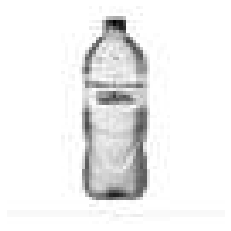

In [249]:
import glob
import random

file_list = glob.glob(test_folder + '/**/**.jpg')
img_path = random.choice(file_list)
img_cat = os.path.split(os.path.dirname(img_path))[1]
img = Image.open(img_path)
X = np.array(img)

REVERSED_IMAGE_CLASSES_MAP = dict(map(reversed, IMAGE_CLASSES_MAP.items()))

def index_from_raw_prediction(prediction):
    return min(round(prediction[0]), len(IMAGE_CLASSES) - 1)

def result_from_raw_prediction(prediction):
    return REVERSED_IMAGE_CLASSES_MAP[index_from_raw_prediction(prediction)]
    
print("Categories: ", REVERSED_IMAGE_CLASSES_MAP, "\n")

result = model.predict(process_images_array([X]))[0]

print("Raw prediction: ", result)
print("Prediction: ", result_from_raw_prediction(result))
print("Actual Category: ", img_cat)

plt.imshow(img)
plt.axis('off')

In [250]:
print("Configuración de RNA MLP Backpropagation definida: [", num_inputs, hidden_layers_neuron_counts, num_outputs," ] ")
print("Cantidad de iteraciones ", epochs_count)

 # evalua al modelo entrenado
loss, accuracy = model.evaluate(_x_test, _y_test)
print("\n> Evaluación del Modelo: ")
print("    - Error: ", loss * 100, "%")
print("    - Exactitud: ", accuracy * 100,"%")
print("\n")

# procesa las imágenes con el modelo 
raw_predictions = model.predict(_x_test)

predictions = list(map(result_from_raw_prediction, raw_predictions))
actual_classes = list(map(lambda y: REVERSED_IMAGE_CLASSES_MAP[y], _y_test))

# muestra reporte de clasificación
print("\nReporte de Clasificación: ")
print(classification_report(actual_classes, predictions))

# muestra matriz de confusion
print('\nMatriz de Confusión: ')
cm = confusion_matrix(actual_classes, predictions, labels=IMAGE_CLASSES)
print(pd.DataFrame(
    cm, 
    index=['r:{:}'.format(x) for x in IMAGE_CLASSES], 
    columns=['p:{:}'.format(x) for x in IMAGE_CLASSES]
  ))

Configuración de RNA MLP Backpropagation definida: [ 4096 [3000, 1024, 512] 1  ] 
Cantidad de iteraciones  100
1/1 [==============================] - 0s 1ms/step - loss: 0.0406 - accuracy: 0.6562

> Evaluación del Modelo: 
    - Error:  4.061754047870636 %
    - Exactitud:  65.625 %



Reporte de Clasificación: 
                  precision    recall  f1-score   support

  bidon_plastico       1.00      1.00      1.00        10
bidon_retornable       1.00      1.00      1.00        11
  botella_normal       1.00      1.00      1.00        11

        accuracy                           1.00        32
       macro avg       1.00      1.00      1.00        32
    weighted avg       1.00      1.00      1.00        32


Matriz de Confusión: 
                    p:bidon_plastico  p:botella_normal  p:bidon_retornable
r:bidon_plastico                  10                 0                   0
r:botella_normal                   0                11                   0
r:bidon_retornable           

In [251]:
import glob
import random

file_list = glob.glob(test_folder + '/**/**.jpg')

def index_from_raw_prediction(prediction):
    return min(round(prediction[0]), len(IMAGE_CLASSES) - 1)

def result_from_raw_prediction(prediction):
    return REVERSED_IMAGE_CLASSES_MAP[index_from_raw_prediction(prediction)]

for img_path in file_list:
  img_cat = os.path.split(os.path.dirname(img_path))[1]
  img = Image.open(img_path)
  X = np.array(img)

  REVERSED_IMAGE_CLASSES_MAP = dict(map(reversed, IMAGE_CLASSES_MAP.items()))

  result = model.predict(process_images_array([X]))[0]

  if result_from_raw_prediction(result) != img_cat:
    print("Raw prediction: ", result)
    print("Prediction: ", result_from_raw_prediction(result))
    print("Actual Category: ", img_cat)

    plt.imshow(img)
    plt.axis('off')

In [252]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/Modelo/model.h5'
model.save(path,save_format='h5')